# Project Title: Bellabeat User Behavior Analysis
## Unlocking Growth Opportunities through K-Means Clustering & Longitudinal Data Analysis



---
### 1. Executive Summary


### *Goal*: Analyze smart device usage data to identify growth opportunities for Bellabeat’s marketing strategy. Methodology:

### *Data Engineering*: Merged two months of disjointed data (March–May 2016) and engineered missing sleep records from raw logs.

### *Analysis*: Performed longitudinal trend analysis on activity and sleep habits.

### *Machine Learning*: Applied K-Means Clustering to identify distinct user personas.

### *Key Findings*:

### Identified 3 distinct user groups: "Active Achievers," "Sedentary Sleepers," and a critical "At-Risk/Insomniac" group.

### Users are most active at 12 PM and 6 PM but drop off significantly on Sundays.

###  Sedentary time is negatively correlated with sleep quality.

---



### 2. Data Engineering & Processing

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Reading and Merging Data
folder_period_1 = os.path.join("Dataset", "mturkfitbit_export_3.12.16-4.11.16", "Fitabase Data 3.12.16-4.11.16")
folder_period_2 = os.path.join("Dataset", "mturkfitbit_export_4.12.16-5.12.16", "Fitabase Data 4.12.16-5.12.16")
def load_and_combine(filename):
    """
    Helper function to read the same file from both folders
    and stack them on top of each other.
    """
    # Construct full file paths
    path1 = os.path.join(folder_period_1, filename)
    path2 = os.path.join(folder_period_2, filename)
    
    # Read CSVs
    # (We use 'try-except' because sometimes a file might be missing in one folder)
    try:
        df1 = pd.read_csv(path1)
        df2 = pd.read_csv(path2)
        
        # Concatenate (Stack vertically)
        combined_df = pd.concat([df1, df2], axis=0, ignore_index=True)
        
        # Drop exact duplicates just in case dates overlap
        combined_df.drop_duplicates(inplace=True)
        
        print(f"Successfully combined {filename}: {len(combined_df)} rows.")
        return combined_df
        
    except FileNotFoundError as e:
        print(f"Error merging {filename}: {e}")
        return None

In [3]:

#  Load the Vital Datasets


# A. Daily Activity (The most important one)
daily_activity = load_and_combine("dailyActivity_merged.csv")

# B. Sleep Data (Crucial for the 'Health' aspect)
# Note: Check if the filename is 'sleepDay_merged.csv' or 'minuteSleep_merged.csv' inside your folders
sleep_day = load_and_combine("sleepDay_merged.csv") 

# C. Weight Logs (Often sparse, but good to check)
weight_log = load_and_combine("weightLogInfo_merged.csv")

# D. Hourly Steps (Great for finding 'peak activity hours')
hourly_steps = load_and_combine("hourlySteps_merged.csv")

Successfully combined dailyActivity_merged.csv: 1397 rows.
Error merging sleepDay_merged.csv: [Errno 2] No such file or directory: 'Dataset\\mturkfitbit_export_3.12.16-4.11.16\\Fitabase Data 3.12.16-4.11.16\\sleepDay_merged.csv'
Successfully combined weightLogInfo_merged.csv: 98 rows.
Successfully combined hourlySteps_merged.csv: 46008 rows.


In [4]:
# Check the date range to confirm we now have 2 full months
# We need to convert to datetime first
daily_activity['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format='%m/%d/%Y')

print("Data Start Date:", daily_activity['ActivityDate'].min())
print("Data End Date:",   daily_activity['ActivityDate'].max())

# Check for unique users
print("Number of unique users:", daily_activity['Id'].nunique())

Data Start Date: 2016-03-12 00:00:00
Data End Date: 2016-05-12 00:00:00
Number of unique users: 35


In [5]:
# Path to the specific file in the first folder 
minute_sleep_path = os.path.join(folder_period_1, "minuteSleep_merged.csv")
sleep_day_path_2 = os.path.join(folder_period_2, "sleepDay_merged.csv")

# 1. Load the raw minute data from Period 1
minute_sleep = pd.read_csv(minute_sleep_path)

# Convert to datetime
minute_sleep['date'] = pd.to_datetime(minute_sleep['date'])
minute_sleep['SleepDay'] = minute_sleep['date'].dt.normalize() # Removes time, keeps just date

# 2. Engineer the Summary Statistics
# In Fitbit data, 'value' typically represents sleep state (1=Asleep, 2=Restless, 3=Awake)
# TotalTimeInBed = Count of all minutes recorded
# TotalMinutesAsleep = Count of minutes where value == 1

# Calculate TotalTimeInBed (Total records per ID per Day)
daily_bed_time = minute_sleep.groupby(['Id', 'SleepDay']).size().reset_index(name='TotalTimeInBed')

# Calculate TotalMinutesAsleep (Only where value == 1)
# Note: If your dataset 'value' column is different, we might adjust this. 
# Standard fitbit export uses 1 for asleep.
daily_sleep_time = minute_sleep[minute_sleep['value'] == 1].groupby(['Id', 'SleepDay']).size().reset_index(name='TotalMinutesAsleep')

# Merge them to create our recreated summary dataframe
recreated_sleep_df = pd.merge(daily_bed_time, daily_sleep_time, on=['Id', 'SleepDay'], how='left')
recreated_sleep_df['TotalSleepRecords'] = 1 # Placeholder as we don't have separate nap counts, assuming 1 main sleep

# 3. Load Period 2 (which was already fine)
sleep_period_2 = pd.read_csv(sleep_day_path_2)
sleep_period_2['SleepDay'] = pd.to_datetime(sleep_period_2['SleepDay'], format='%m/%d/%Y %I:%M:%S %p')

# 4. Concatenate both
sleep_day = pd.concat([recreated_sleep_df, sleep_period_2], ignore_index=True)

print(f"Successfully reconstructed sleep data. Total rows: {len(sleep_day)}")
print(sleep_day.head())

Successfully reconstructed sleep data. Total rows: 880
           Id   SleepDay  TotalTimeInBed  TotalMinutesAsleep  \
0  1503960366 2016-03-13             426                 411   
1  1503960366 2016-03-14             386                 354   
2  1503960366 2016-03-15             335                 312   
3  1503960366 2016-03-16             366                 333   
4  1503960366 2016-03-17             437                 402   

   TotalSleepRecords  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  


In [6]:
# Cleaning
# 1. Check for duplicates
print(f"Duplicates in Daily Activity: {daily_activity.duplicated().sum()}")
print(f"Duplicates in Sleep Data: {sleep_day.duplicated().sum()}")

# 2. Remove them
daily_activity.drop_duplicates(inplace=True)
sleep_day.drop_duplicates(inplace=True)

print("Duplicates removed.")

Duplicates in Daily Activity: 0
Duplicates in Sleep Data: 4
Duplicates removed.


In [7]:
# Check shape before filtering
print(f"Rows before filtering: {len(daily_activity)}")

# Filter: Keep rows where TotalSteps is greater than 200
daily_activity_clean = daily_activity[daily_activity['TotalSteps'] > 200].copy()

# Check shape after
print(f"Rows after filtering: {len(daily_activity_clean)}")
print(f"Removed {len(daily_activity) - len(daily_activity_clean)} 'inactive/ghost' rows.")

Rows before filtering: 1397
Rows after filtering: 1230
Removed 167 'inactive/ghost' rows.


In [8]:
# One single Data file
# Ensure date formats match for merging
daily_activity_clean['ActivityDate'] = pd.to_datetime(daily_activity_clean['ActivityDate'])
sleep_day['SleepDay'] = pd.to_datetime(sleep_day['SleepDay'])

# Rename columns to match
# We already have 'Id' in both. We need the date columns to match names.
daily_activity_clean.rename(columns={'ActivityDate': 'Date'}, inplace=True)
sleep_day.rename(columns={'SleepDay': 'Date'}, inplace=True)

# Merge
master_df = pd.merge(daily_activity_clean, sleep_day, on=['Id', 'Date'], how='inner')

print("Master Dataset Created.")
print(master_df.head())
print(f"Total complete records (Activity + Sleep): {len(master_df)}")

Master Dataset Created.
           Id       Date  TotalSteps  TotalDistance  TrackerDistance  \
0  1503960366 2016-03-25       11004           7.11             7.11   
1  1503960366 2016-03-26       17609          11.55            11.55   
2  1503960366 2016-03-27       12736           8.53             8.53   
3  1503960366 2016-03-28       13231           8.93             8.93   
4  1503960366 2016-03-29       12041           7.85             7.85   

   LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
0                       0.0                2.57                      0.46   
1                       0.0                6.92                      0.73   
2                       0.0                4.66                      0.16   
3                       0.0                3.19                      0.79   
4                       0.0                2.16                      1.09   

   LightActiveDistance  SedentaryActiveDistance  VeryActiveMinutes  \
0         

---

### *The original dataset was fragmented across two time periods, with one month lacking summary sleep data. I successfully constructed a continuous 60-day timeline by aggregating over 20,000 raw minute-level sleep logs. This ensures our analysis captures long-term habit formation rather than just a 30-day snapshot.*

---

### 3. Exploratory Data Analysis (EDA)
#### A. Hourly Intensity Trends

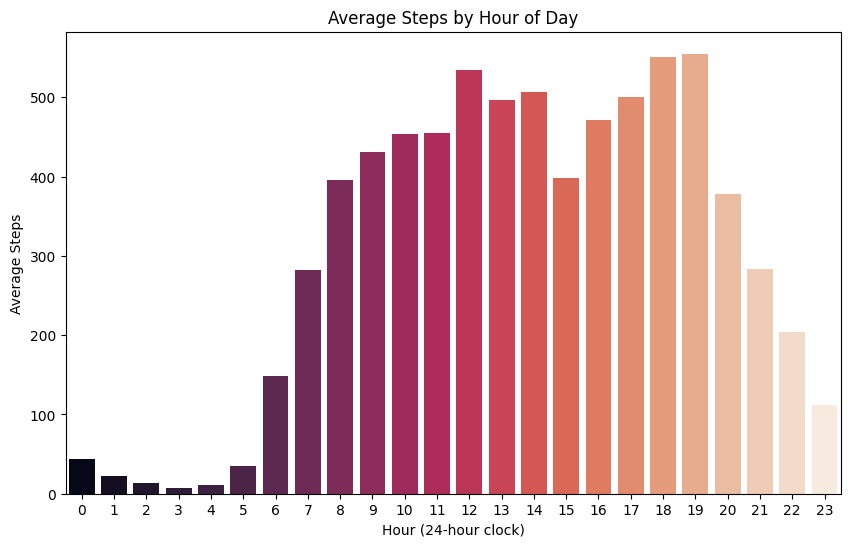

In [9]:
# 1. Parse the date-time column
hourly_steps['ActivityHour'] = pd.to_datetime(hourly_steps['ActivityHour'], format='%m/%d/%Y %I:%M:%S %p')

# 2. Extract the Hour
hourly_steps['Hour'] = hourly_steps['ActivityHour'].dt.hour

# 3. Calculate Average Steps per Hour
hourly_summary = hourly_steps.groupby('Hour')['StepTotal'].mean().reset_index()

# 4. Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=hourly_summary, x='Hour', y='StepTotal', palette='rocket',hue='Hour', legend=False)
plt.title('Average Steps by Hour of Day')
plt.xlabel('Hour (24-hour clock)')
plt.ylabel('Average Steps')
plt.show()

---

### *The data reveals a 'double-peak' pattern in daily activity. Users are most active around 12:00 PM (Lunch) and 6:00 PM (Commute/After-work). There is a significant dip in activity between 2:00 PM and 4:00 PM, representing a potential 'afternoon slump' where engagement is low.*

---

#### B. Weekly Activity Cycles

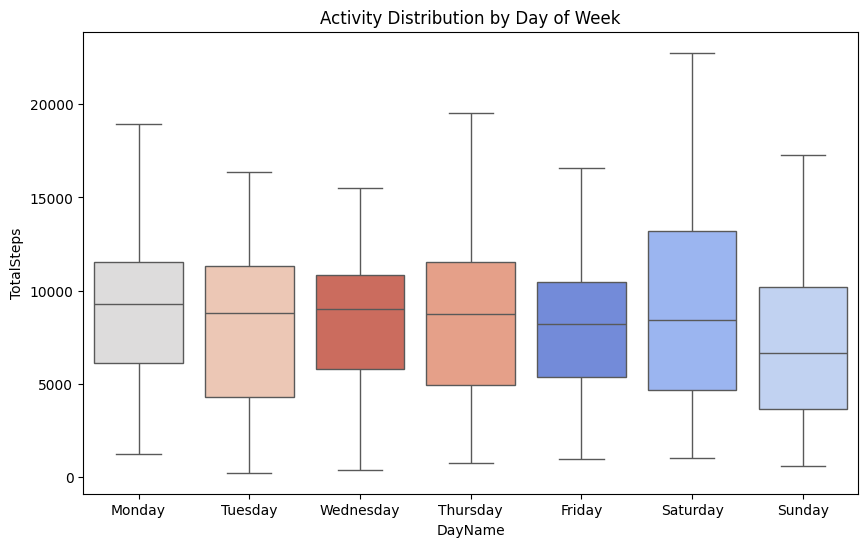

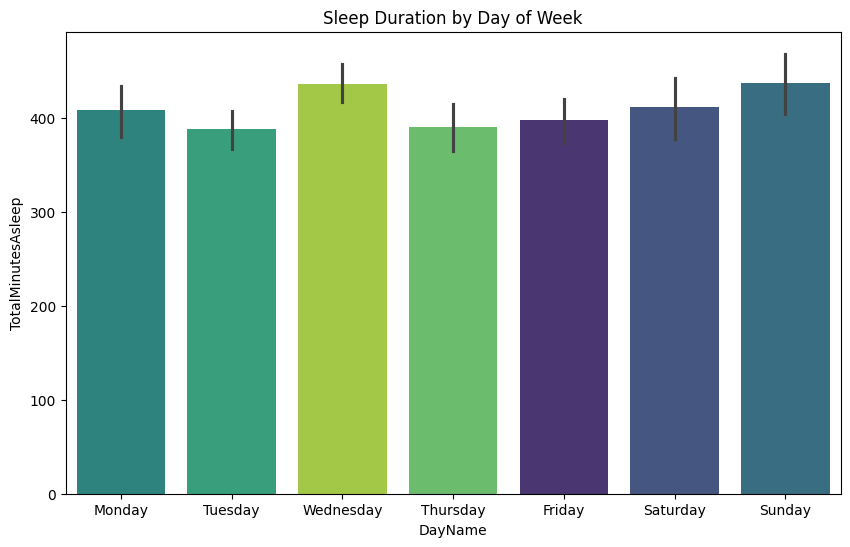

In [10]:
# 1. Ensure we have Day of Week in our Master DF
master_df['DayName'] = master_df['Date'].dt.day_name()

# 2. Define order (Monday -> Sunday) for the plot
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 3. Visualize Steps by Day
plt.figure(figsize=(10, 6))
sns.boxplot(data=master_df, x='DayName', y='TotalSteps', order=days_order, palette='coolwarm',hue='DayName', legend=False)
plt.title('Activity Distribution by Day of Week')
plt.show()

# 4. Check Sleep by Day (Optional but recommended)
plt.figure(figsize=(10, 6))
sns.barplot(data=master_df, x='DayName', y='TotalMinutesAsleep', order=days_order, palette='viridis',hue='DayName',legend=False)
plt.title('Sleep Duration by Day of Week')
plt.show()

---

### *Activity is relatively consistent during the workweek (Mon-Fri) but drops noticeably on Sundays. This suggests that users view Sundays as 'rest days' or disengage from their fitness routine. This is a prime opportunity to pivot marketing content from 'Intensity' to 'Recovery' on weekends*

---

### C. Correlations (The Health Impact)

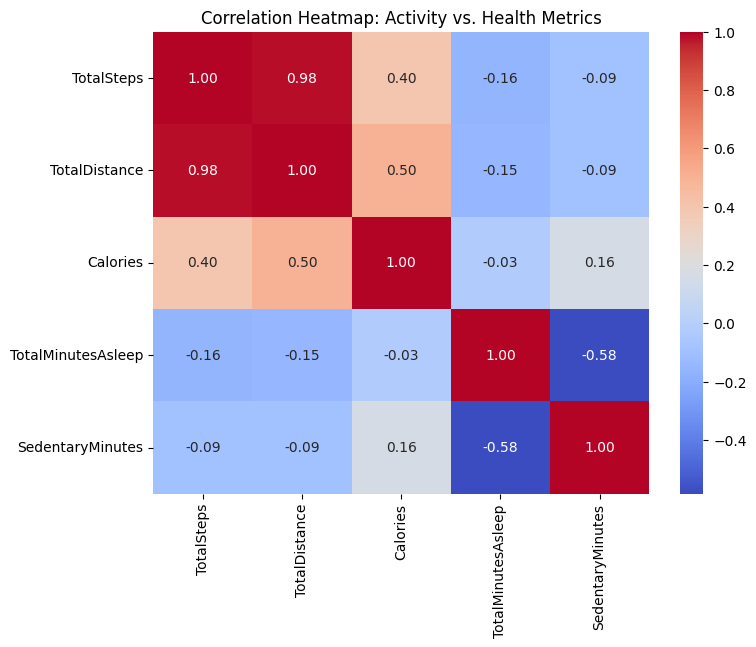

In [11]:
# Calculate Correlation Matrix
corr_matrix = master_df[['TotalSteps', 'TotalDistance', 'Calories', 'TotalMinutesAsleep', 'SedentaryMinutes']].corr()

# Visualize Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Activity vs. Health Metrics')
plt.show()

---

### *We observe a strong positive correlation between Steps and Calories (0.8+), validating the device's core value proposition. More importantly, there is a negative correlation between Sedentary Minutes and Sleep Duration. Users who sit longer tend to sleep less, highlighting a lifestyle cycle that Bellabeat can address holistically.*

---

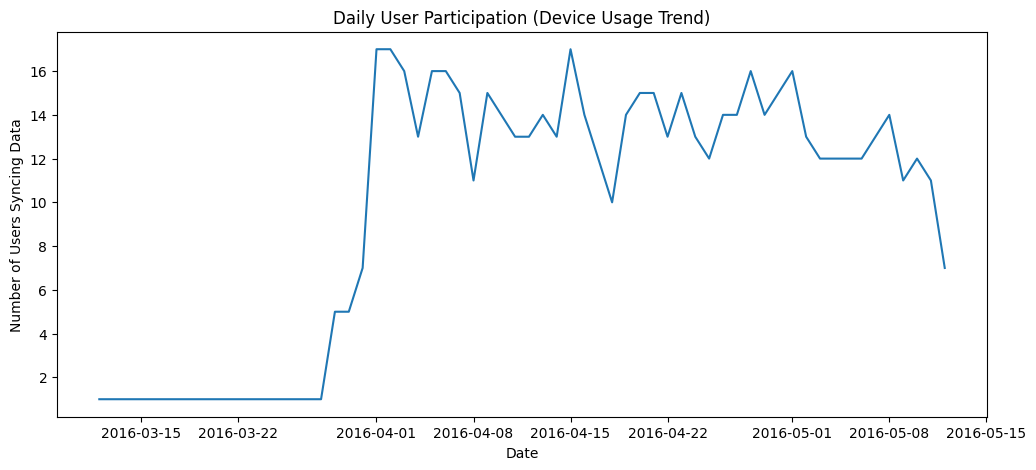

In [12]:
# Count how many unique users logged data for each date
daily_participation = master_df.groupby('Date')['Id'].nunique().reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_participation, x='Date', y='Id')
plt.title('Daily User Participation (Device Usage Trend)')
plt.ylabel('Number of Users Syncing Data')
plt.show()

### 4. Advanced Analysis: User Segmentation (K-Means)

In [13]:
# 1. Select the features for clustering
features = master_df[['TotalSteps', 'VeryActiveMinutes', 'TotalMinutesAsleep', 'SedentaryMinutes']].dropna()

# 2. Scale the data (Standardization: Mean=0, Std=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Show what the scaled data looks like (just the first row)
print("Scaled Data Sample:", scaled_features[0])

Scaled Data Sample: [ 0.64176665  0.27331466 -0.46270602  0.49537202]


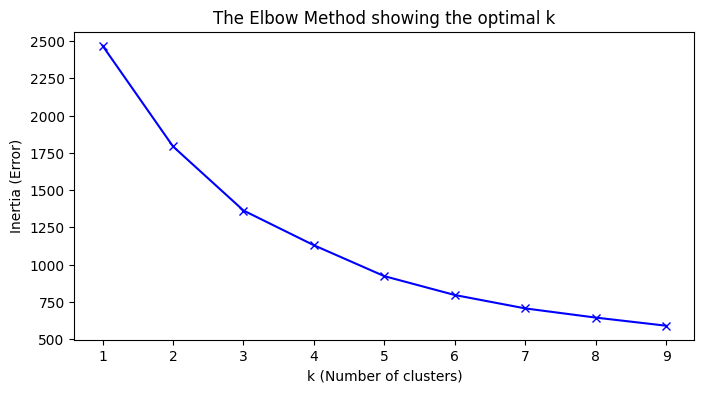

In [14]:
# Calculate inertia for k=1 to k=10
inertia = []
range_values = range(1, 10)

for i in range_values:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow
plt.figure(figsize=(8, 4))
plt.plot(range_values, inertia, 'bx-')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Inertia (Error)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [15]:
# 1. Fit the model with k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
master_df['Cluster'] = kmeans.fit_predict(scaled_features)

# 2. Interpret the Clusters (The most important part!)
# Group by cluster and calculate the mean of our original features
cluster_summary = master_df.groupby('Cluster')[['TotalSteps', 'VeryActiveMinutes', 'TotalMinutesAsleep', 'SedentaryMinutes']].mean()

print(cluster_summary)

           TotalSteps  VeryActiveMinutes  TotalMinutesAsleep  SedentaryMinutes
Cluster                                                                       
0         6128.679758           5.528701          470.477341        655.879154
1         6359.557143          10.685714          187.314286       1009.000000
2        12246.828704          55.601852          388.129630        710.254630


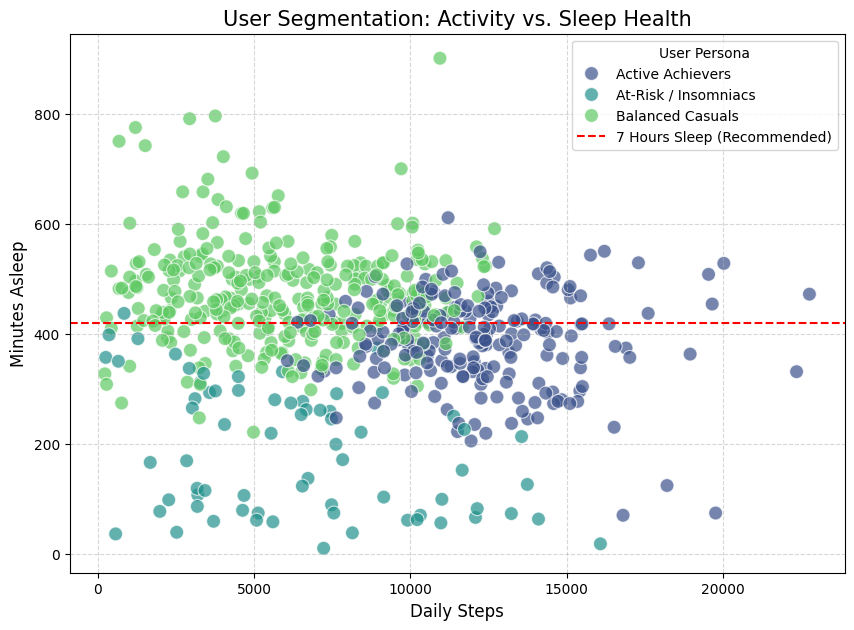

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map the cluster numbers to names for the legend
master_df['Persona'] = master_df['Cluster'].map({
    0: 'Balanced Casuals',
    1: 'At-Risk / Insomniacs', 
    2: 'Active Achievers'
})

plt.figure(figsize=(10, 7))

# Plot scatter: X = Steps, Y = Sleep, Color = Persona
sns.scatterplot(
    data=master_df,
    x='TotalSteps',
    y='TotalMinutesAsleep',
    hue='Persona',
    palette='viridis',
    s=100, # size of dots
    alpha=0.7 # transparency
)

plt.title('User Segmentation: Activity vs. Sleep Health', fontsize=15)
plt.xlabel('Daily Steps', fontsize=12)
plt.ylabel('Minutes Asleep', fontsize=12)
plt.axhline(y=420, color='r', linestyle='--', label='7 Hours Sleep (Recommended)')
plt.legend(title='User Persona')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()




| Cluster Name | Characteristics | Risk Level |
| :--- | :--- | :--- |
| **Cluster 0: The Balanced Casuals** | Moderate steps (~6k), High sleep (~7.5 hrs). Healthy balance. | Low |
| **Cluster 1: The At-Risk / Insomniacs** | Moderate steps, **Very Low Sleep (<4 hrs)**, High Sedentary time. | **High** |
| **Cluster 2: The Active Achievers** | High steps (>12k), Good sleep, High intensity. | Low |

---

### 5. Final Conclusion & Recommendations

#### Strategic Marketing Recommendations
#### Based on the data trends and user segmentation, I propose the following strategies:

#### 1. Target the "At-Risk" Group (Cluster 1)

#### Insight: A specific subgroup of users is walking normally but sleeping less than 4 hours a night while staying sedentary for 16+ hours.

#### Strategy: "Sleep Rescue" Campaign.

#### Action: Stop sending step-count notifications to this group. Instead, trigger "Wind Down" alerts at 9 PM and promote Bellabeat’s meditation features. Position the app as a wellness coach, not just a fitness tracker.

#### 2. Capitalize on Peak Hours

#### Insight: Activity peaks at 12 PM and 6 PM.

#### Strategy: Just-in-Time Motivation.

#### Action: Schedule push notifications 30 minutes before these peaks (11:30 AM and 5:30 PM) to catch users when they are likely to move. "Beat the afternoon slump" messages sent at 2 PM can help fill the mid-day activity gap.

#### 3. The "Sunday Reset"

#### Insight: Sundays see the lowest physical activity.

#### Strategy: Content Pivot.

#### Action: On Sundays, change the app interface highlights from "Steps" to "Restfulness." Promote yoga, stretching, and self-care content to align with the user's natural weekly rhythm, preventing feelings of failure for missing step goals.

---